In [ ]:
import os
import actipy
import pandas as pd
from glob import glob
from tqdm import tqdm
from nimbaldetach import nimbaldetach
import numpy as np

DATA_DIR = '/data/ForbowSleep/TestingBin/'

all_files = glob(os.path.join(DATA_DIR, "**/*.bin"), recursive=True)
files_to_process = [fname for fname in all_files]
chunk_size = 250
chunk_size2 = 12

#This will be used for non-wear detection
##Future plans - Include windows inbetween for non-wear detection

#nonwear- rule 1 
step = 45000
window = 180000
nonwear_flags = []


##Non-Wear Rule 4 - Final 24 hours
window_rows = 4320000
bridge_gap_max = 540000
prior_nonwear_min = 180000


for i, fname in tqdm(enumerate(sorted(files_to_process)), total=len(files_to_process), desc="Processing files"):
    try:
        print(f"Processing {i+1}/{len(files_to_process)}: {fname}")
        # Read device data
        df, info = actipy.read_device(fname, lowpass_hz=100, calibrate_gravity=True, detect_nonwear=False, verbose=False)
        x_nan_count = df['x'].isna().sum()  #For some reason a few people get NaNs 
        
        #Non-Wear Examination: Rule 1
        for start in range(0, len(df) - window, step):
            chunk = df.iloc[start : start + window]

            std_x = chunk['x'].std()
            std_y = chunk['y'].std()
            std_z = chunk['z'].std()

            low_std_count = sum(s < 0.03 for s in [std_x, std_y, std_z])
            flag = low_std_count >= 2
            nonwear_flags.append((start, start + window, flag))
        df['nonwear'] = False
        # Apply true or false values
        for start, end, flag in nonwear_flags:
            if flag:
                df.iloc[start:end, df.columns.get_loc('nonwear')] = True

    #Non-Wear Examination: Rule 4a
        df_tail = df.iloc[-window_rows:].copy()
        nonwear_array = df_tail['nonwear'].values.astype(bool)
        # Find start and end indices of wear-time runs (nonwear == False)
        is_wear = ~nonwear_array
        diff = np.diff(is_wear.astype(int))
        wear_starts = np.where(diff == 1)[0] + 1  # wear starts
        wear_ends = np.where(diff == -1)[0] + 1   # wear ends
        
        if is_wear[0]:
            wear_starts = np.insert(wear_starts, 0, 0)
        if is_wear[-1]:
            wear_ends = np.append(wear_ends, len(is_wear))
            
        #Bridging
        for start, end in zip(wear_starts, wear_ends):
            duration = end - start
            if duration < bridge_gap_max:
                # Check prior nonwear duration
                prior_end = start
                # Walk backwards from `start - 1` until value is not True
                prior_start = prior_end
                while prior_start > 0 and nonwear_array[prior_start - 1]:
                    prior_start -= 1
                prior_nonwear_length = prior_end - prior_start

                if prior_nonwear_length >= prior_nonwear_min:
                    # Flip the wear-time segment to nonwear
                    nonwear_array[start:end] = True
        df_tail['nonwear'] = nonwear_array
        df.iloc[-window_rows:] = df_tail


    #Non-Wear Examination: Rule 4b
        df_start = df.iloc[:540_000].copy()
        nonwear_array = df_start['nonwear'].values.astype(bool)
        diff = np.diff(nonwear_array.astype(int))         # Check if there’s a transition from False to True
        transition_to_nonwear = np.where(diff == 1)[0]  # index where it goes from 0 to 1
        if len(transition_to_nonwear) > 0 and nonwear_array[0] == False:
            nonwear_array[:] = True
        df_start['nonwear'] = nonwear_array
        df.iloc[:540_000] = df_start

    #Non-Wear Examination: Rule 4c
        df_start['nonwear'] = nonwear_array
        df.iloc[-540_000:] = df_start
        diff = np.diff(nonwear_array.astype(int))
        transition_to_nonwear = np.where(diff == 1)[0]
        if len(transition_to_nonwear) > 0 and nonwear_array[540000] == False:
                nonwear_array[:] = True
        df_start['nonwear'] = nonwear_array
        df.iloc[-540_000:] = df_start
            





    #Begin Compression
        #This will compress it into 5 second rolling medians
        num_chunks = len(df)// chunk_size
        trimmed_df = df.iloc[:num_chunks * chunk_size].copy()
        trimmed_df['group'] = np.repeat(np.arange(num_chunks), chunk_size)
        trimmed_df['time'] = trimmed_df.index  # Convert index to a column

        median_df = trimmed_df.groupby('group').median(numeric_only=True)
        time_df = trimmed_df.groupby('group').first()[['time']]
        compressed_df = median_df.join(time_df).reset_index(drop=True)
        
        compressed_df['angle_z'] = np.arctan((compressed_df['z']/(compressed_df['x']**2 + compressed_df['y']**2)))*180/np.pi
        compressed_df['abs_diff'] = compressed_df['angle_z'].diff().abs()
        
        #Here we comrpess it into 1 minute rolling medians
        num_chunks = len(compressed_df) // chunk_size2
        trimmed_df = compressed_df.iloc[:num_chunks * chunk_size2].copy()
        trimmed_df['group'] = np.repeat(np.arange(num_chunks), chunk_size2)
        trimmed_df['time'] = trimmed_df['time']  # Optional: keep 'time' column

        # Re-compress
        median_df = trimmed_df.groupby('group').median(numeric_only=True)
        time_df = trimmed_df.groupby('group').first()[['time']]
        compressed_df2 = median_df.join(time_df).reset_index(drop=True)


    #Sleep Detection
        compressed_df2['sleep'] = False
        shifted_time = compressed_df2['time'] - pd.Timedelta(hours=12)
        compressed_df2['shifted_date'] = shifted_time.dt.date
        grouped = compressed_df2.groupby('shifted_date')
        
        # Process each group separately
        for day, group_df in grouped:
            # Calculate 10th percentile of abs_diff for this day, times it by 15
            p10 = group_df['abs_diff'].quantile(0.10)*15

            #Below 10 percentile (times 15)
            sleep_mask = group_df['abs_diff'] < p10
            
            #Now updates the sleep column in main 
            compressed_df2.loc[group_df.index, 'sleep'] = sleep_mask


 
        compressed_df2.drop(columns=['shifted_date'], inplace=True)

    

        


    except Exception as e:
        print(f"Error processing {fname}: {e}")
        continue

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1/1: /data/ForbowSleep/TestingBin/800-0007-010_left wrist_068202_2023-03-28 13-32-56.bin
Skipping lowpass filter: data sample rate 50.0 too low for cutoff rate 100


Processing files: 100%|██████████| 1/1 [01:38<00:00, 98.34s/it]


In [10]:
print((df['nonwear'] == False).sum()/len(df))

print(compressed_df2)
print((compressed_df2['sleep'] == True).sum()/len(compressed_df2))

0.9034718736605426
              x         y         z  temperature  nonwear    angle_z  \
0      0.087671 -0.991670 -0.016014         19.4      1.0  -0.925725   
1      0.087671 -0.991670 -0.016014         19.4      1.0  -0.925725   
2      0.087671 -0.991670 -0.016014         19.4      1.0  -0.925725   
3      0.087671 -0.991670 -0.016014         19.4      1.0  -0.925725   
4      0.087671 -0.991670 -0.016014         19.4      1.0  -0.925725   
...         ...       ...       ...          ...      ...        ...   
21595 -0.266042  0.873617  0.397614         19.9      1.0  25.490103   
21596 -0.266042  0.873617  0.397614         19.9      1.0  25.490103   
21597 -0.266042  0.873617  0.397614         19.9      1.0  25.490103   
21598 -0.266042  0.873617  0.397614         19.9      1.0  25.490103   
21599 -0.266042  0.873617  0.397614         19.9      1.0  25.490103   

       abs_diff                    time  sleep  
0           0.0 2023-03-11 09:00:00.500  False  
1           0.0 20

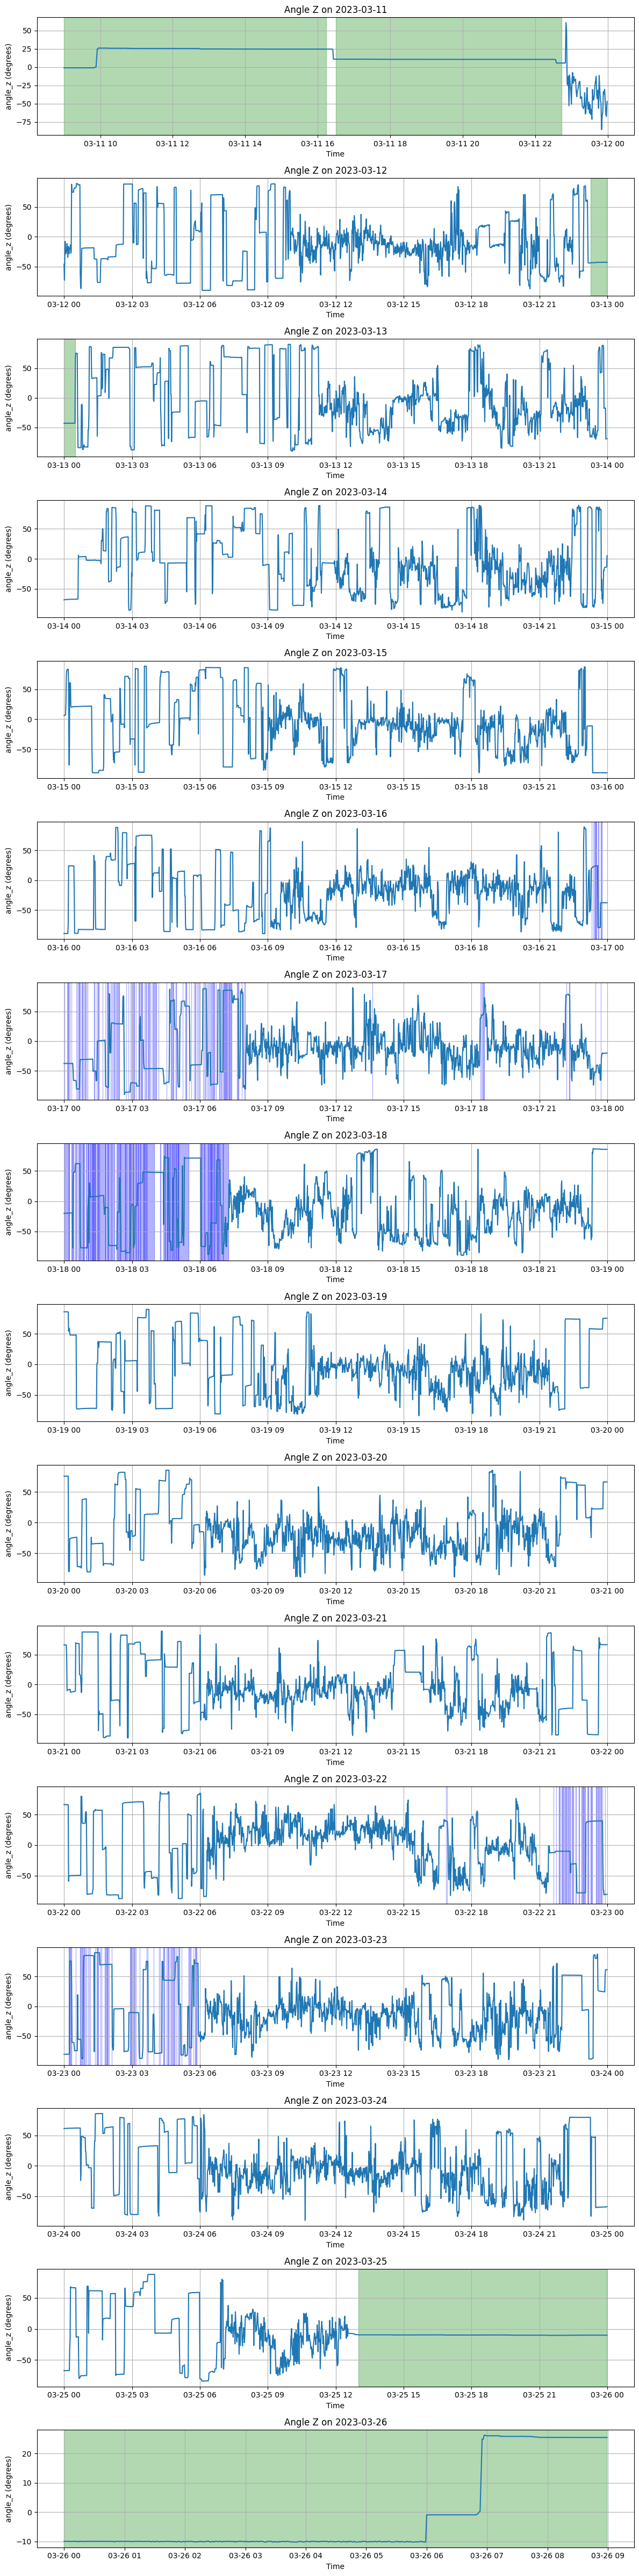

In [11]:
import matplotlib.pyplot as plt
import numpy as np 

compressed_df2['time'] = pd.to_datetime(compressed_df2['time'])
grouped = compressed_df2.groupby(compressed_df2['time'].dt.date)

num_days = len(grouped)
fig, axes = plt.subplots(num_days, 1, figsize=(12, 3 * num_days), sharex=False)

if num_days == 1:
    axes = [axes]  # make iterable if only one day

for ax, (day, group) in zip(axes, grouped):
    ax.plot(group['time'], group['angle_z'], linestyle='-')
    ax.set_title(f"Angle Z on {day}")
    ax.set_xlabel("Time")
    ax.set_ylabel("angle_z (degrees)")
    ax.grid(True)

    is_nonwear = group['nonwear'].values
    times = group['time'].values
    diff = np.diff(is_nonwear.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if is_nonwear[0]:
        starts = np.insert(starts, 0, 0)
    if is_nonwear[-1]:
        ends = np.append(ends, len(is_nonwear))

    for start, end in zip(starts, ends):
        ax.axvspan(times[start], times[end - 1], color='green', alpha=0.3)
    
    is_sleep = group['sleep'].values
    diff2 = np.diff(is_sleep.astype(int))
    starts2 = np.where(diff2 == 1)[0] + 1
    ends2 = np.where(diff2 == -1)[0] + 1

    if is_sleep[0]:
        starts = np.insert(starts, 0, 0)
    if is_sleep[-1]:
        ends = np.append(ends, len(is_sleep))
    
    for start2, end2 in zip(starts2, ends2):
            ax.axvspan(times[start2], times[end2 - 1], color='blue', alpha=0.3)




plt.tight_layout()
plt.show()